# Data Exploration and algorithem/ data preprocessing choice

In [1]:
!pip install optuna -q

In [106]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import optuna
import seaborn as sns

# Read File

In [96]:

X_test = pd.read_csv('../data/Xte.csv',sep=',',index_col=0)
X_train = pd.read_csv('../data/Xtr.csv',sep=',',index_col=0)

X_test_mat100 = pd.read_csv('../data/Xte_mat100.csv',sep=' ',header=None)
X_train_mat100 = pd.read_csv('../data/Xtr_mat100.csv',sep=' ',header=None)

y = pd.read_csv('../data/Ytr.csv',sep=',',index_col=0)

In [97]:
X_train.head()

,seq
Id,
0,GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGA...
1,CGGCCTGGGGGCCACATGTGAGTGCTTACCTGTGTGGGGATGAGGG...
2,GACAACGCCGCTGTCAGCCGCCTTCGACTCACCTGGGAGGTGATGA...
3,GCCTCCCTTGGCACCACGGGAGACCAGTTTTGGAGGGGCGGGGCTG...
4,GCACTACTACACCCATTGCTGTAATAGTAAGTGCCGGTGCCTTCAC...


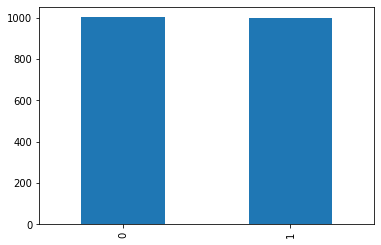

In [98]:
y['Bound'].value_counts().plot.bar()

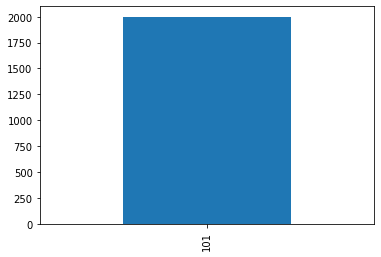

In [99]:
X_train['Count'] = X_train.seq.apply(lambda x:len(x))
X_train['Count'].value_counts().plot.bar()

# Models To test whih is good representation

In [125]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


def test_data(X,y):
    results = {}
    X=scale(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    classifier = SVC(kernel = 'linear', C = 0.1, gamma = 0.01)
    classifier.fit(X_train, y_train)
    results['svm'] = classifier.score(X_test,y_test)

    clf = LogisticRegression(random_state=0,penalty='l2').fit(X, y)
    results['lr'] = clf.score(X_test,y_test)
    
    return results

# Explore representation methods
[methods](https://medium.com/analytics-vidhya/demystify-dna-sequencing-with-machine-learning-and-python-bdbaeb177f56)

- this results dectate the smaller resut we must get from our models 

In [126]:
# 1. TESTING THE DEFAULT DATA WE HAVE
test_data(X_train_mat100,y.values.flatten())

{'lr': 0.65, 'svm': 0.58}

In [127]:
# Ordinal encoding DNA sequence data
import re
def string_to_array(seq_string):
    seq_string = seq_string.lower()
    seq_string = re.sub('[^acgt]', 'n', seq_string)
    seq_string = np.array(list(seq_string))
    return seq_string

# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, lets say n
    return float_encoded

X_tr = X_train.seq.values
X_list = []
for i in X_tr:
    X_list.append(ordinal_encoder(string_to_array(i)))
    
    
test_data(np.array(X_list),y.values.flatten())

{'lr': 0.6466666666666666, 'svm': 0.5783333333333334}

In [131]:
#DNA sequence as a “language”, known as k-mer counting
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
def get_n_grams(data1,n):
    X_train = []
    X_test = []

    cv = CountVectorizer(ngram_range=(5,5))
    for i in data1:
        sentence = ' '.join(getKmers(i[0], size=n))
        X_train.append(sentence)
        
    X_cocat = X_train
    X = cv.fit_transform(X_cocat).toarray()
    return X

X_preprocess = get_n_grams(X_train.values,6)

test_data(X_preprocess,y.values.flatten())

KeyboardInterrupt: 

In [129]:
# Count Vectorizer 
def get_n_grams(data1):
    cv = CountVectorizer(analyzer='char',ngram_range=(5,5))
    X = cv.fit_transform(data1).toarray()
    return X

X_preprocess = get_n_grams(X_train.seq.values.flatten())

test_data(X_preprocess,y.values.flatten())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'lr': 0.9283333333333333, 'svm': 0.6016666666666667}

In [130]:
# Count Vectorizer 
def get_tf_idf_grams(data1):
    cv = TfidfVectorizer(analyzer='char',ngram_range=(5,5))
    X = cv.fit_transform(data1).toarray()
    return X

X_preprocess = get_n_grams(X_train.seq.values.flatten())

test_data(X_preprocess,y.values.flatten())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'lr': 0.9316666666666666, 'svm': 0.5933333333333334}